In [2]:
import os

import seaborn as sns
import pandas as pd

base_dir = 'results'

dataframes = []

EXCEPTION = 30303030303

databases = ['FlatGraph', 'OverflowDB', 'TinkerGraph', 'Neo4j']
palette = sns.color_palette("husl", len(databases))
# JAR files in ascending order of size
projects = ['Cli',
            'Csv',
            'Jacksonxml',
            'Gson',
            'Codec',
            'Jsoup',
            'Jxpath',
            'Mockito',
            'Collections',
            'Time',
            'Lang',
            'Jacksoncore',
            'Compress',
            'Jacksondatabind',
            'Chart',
            'Math',
            'Closure']


def map_driver_name(name: str) -> str:
    if name == "overflowdb":
        return "OverflowDB"
    elif name == "tinkergraph":
        return "TinkerGraph"
    elif name == "neo4j-embedded":
        return "Neo4j"
    elif name == "flatgraph":
        return "FlatGraph"
    else:
        return "Unknown ({})".format(name)

cols = ['Database', 'Project', 'Size', 'Unit']

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith("DS_Store"):
            continue
        file_path = os.path.join(root, file)
        parts = file_path.split(os.sep)
        driver = map_driver_name(parts[1])
        project = parts[2].title()
        if file == 'storage_size.txt':
            if os.path.getsize(file_path) == 0:
                print(f"Skipping empty file: {file_path}")
                continue
            else:
                with open(file_path, 'r') as f:
                    file_size = float(f.readline().strip())
                    
                data = [[driver, project, file_size, "bytes"]]
                df = pd.DataFrame(data, columns=cols)
            if not df.empty:
                dataframes.append(df)

final_df = pd.concat(dataframes, ignore_index=True)

for d in databases:
    for p in projects:
        df = final_df
        result = df[(df["Database"] == d) & (df["Project"] == p)]
        if result.empty:
            data = [[d, p, EXCEPTION, "bytes"]]
            final_df = pd.concat([pd.DataFrame(data, columns=cols), final_df], ignore_index=True)


final_df['Size'] = final_df['Size'].apply(lambda x: x / (1024 * 1024) if x != EXCEPTION else x)
final_df.loc[:, 'Unit'] = 'MB'


print(final_df)


      Database      Project          Size Unit
0        Neo4j      Closure  3.030303e+10   MB
1        Neo4j         Math  3.030303e+10   MB
2   OverflowDB      Closure  2.172266e+02   MB
3   OverflowDB     Compress  6.104688e+01   MB
4   OverflowDB  Jacksoncore  5.810938e+01   MB
..         ...          ...           ...  ...
63       Neo4j        Jsoup  1.108205e+02   MB
64       Neo4j          Csv  1.979244e+01   MB
65       Neo4j       Jxpath  1.189985e+02   MB
66       Neo4j      Mockito  1.160008e+02   MB
67       Neo4j  Collections  1.680267e+02   MB

[68 rows x 4 columns]


### Plotting

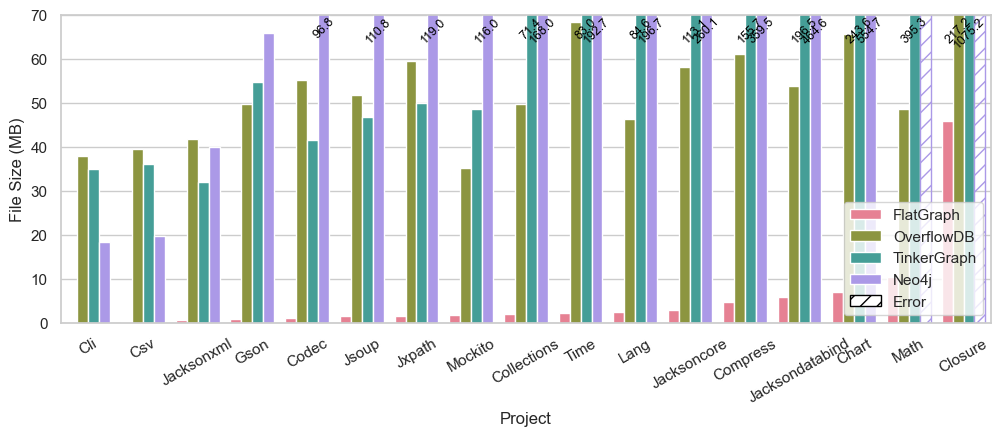

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

df = final_df


fig, ax1 = plt.subplots(figsize=(12, 4))
sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(df['Database'].unique()))
sns.barplot(x="Project", y="Size", hue="Database", #yerr=df["Error"], 
            data=df, ax=ax1, palette=palette, order=projects,
            hue_order=databases)

y_limit = 70

ax1.set_xlabel('Project')
ax1.set_ylabel(f'File Size ({df["Unit"].iloc[0]})')

ax1.set_ylim(top=y_limit)

for i, patch in enumerate(ax1.patches):

    h = int(patch.get_height())
    if h == EXCEPTION:
        original_color = patch.get_facecolor()
        patch.set_hatch('//')
        patch.set_facecolor('none')
        patch.set_edgecolor(original_color)
    elif patch.get_height() >= y_limit:
        yval = patch.get_height()
        ax1.text(
            patch.get_x() + patch.get_width() / 2,
            min(yval, ax1.get_ylim()[1]) - 0.1,
            f'{yval:.1f}',
            ha='center',
            va='top',
            color='black',
            fontsize=9,
            rotation=45
        )

plt.xticks(rotation=30)

handles, labels = plt.gca().get_legend_handles_labels()

handles.append(Patch(facecolor='white', edgecolor='black', hatch='//', label='Error'))
plt.legend(handles=handles, loc='lower right')

plt.savefig("storage.pdf", format='pdf', bbox_inches='tight')
plt.show()
